#Pre-proocess data

In [1]:
! pip install talib-binary
! gdown 17OYeD6dlfwX28FNoUpqXkLVpzjUtTCRW
! unzip /content/ThaiDepression.zip
! pip install -qqq greykite
! pip install --upgrade pandas
! python -m pip uninstall matplotlib
! pip install matplotlib==3.1.3
! pip install tsai
! pip install sktime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 15.3 MB/s 
Downloading...
From: https://drive.google.com/uc?id=17OYeD6dlfwX28FNoUpqXkLVpzjUtTCRW
To: /content/ThaiDepression.zip
100% 8.78M/8.78M [00:00<00:00, 175MB/s]
Archive:  /content/ThaiDepression.zip
   creating: ThaiDepression/2016/
  inflating: ThaiDepression/2016/ahb-2016-10.csv  
  inflating: ThaiDepression/2016/ahb-2016-10.pdf  
  inflating: ThaiDepression/2016/ahb-2016-11.csv  
  inflating: ThaiDepression/2016/ahb-2016-11.pdf  
  inflating: ThaiDepression/2016/ahb-2016-12.csv  
  inflating: ThaiDepression/2016/ahb-2016-12.pdf  
   creating: ThaiDepression/2017/
  inflating: ThaiDepression/2017/ahb-2017-01.csv  
  inflating: ThaiDepression/2017/ahb-2017-01.pdf  
  inflating: ThaiDepression/2017/ahb-2017-02.csv  
  inflating: ThaiDepression/2017/ahb-2017-02.pdf  
  inflating: ThaiDepression/2017/ahb-2017-03.csv  
  inflating: ThaiD

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 241 kB 15.1 MB/s 
     |████████████████████████████████| 2.5 MB 77.6 MB/s 
     |████████████████████████████████| 750.6 MB 10 kB/s 
     |████████████████████████████████| 19.1 MB 80.2 MB/s 
     |████████████████████████████████| 19.1 MB 951 kB/s 
     |████████████████████████████████| 21.0 MB 105.6 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.1

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import talib
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.forecaster import Forecaster 
from greykite.framework.templates.model_templates import ModelTemplateEnum
from greykite.framework.utils.result_summary import summarize_grid_search_results
import plotly
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import  plot_pacf
from statsmodels.tsa.stattools import pacf
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tsai.all import *
from tsai.inference import load_learner
from pandas import Series
from sklearn.preprocessing import MinMaxScaler

In [3]:
path = "/content/ThaiDepression/"
year_list = os.listdir(path)
year_list.sort()

df_list = []
name_list = []
 
for i in range(len(year_list)):
    file_list = os.listdir(path+year_list[i])
    file_list.sort()
    for f in file_list:
        if '.csv' in f:
            # print(f)
            name_list.append(f[4:11])
            df_list.append(pd.read_csv(path+year_list[i]+'/'+f, header=None, index_col=False))


finished_process = []
for i in range(len(df_list[0])):
    finished_process.append(pd.DataFrame(df_list[0].iloc[i,:]).T.reset_index(drop=True))
    finished_process[i]['y-m'] = name_list[0]


i=1
while(i != len(df_list)):
    # print('i=' + str(i))
    if len(df_list[i]) == 89:
        insert = { 0 : np.nan, 1 : np.nan, 2 : np.nan, 3 : np.nan, 4 : np.nan, 5 : np.nan, 6 :np.nan, 7 : np.nan, 8 : np.nan, 9 : np.nan, 'y-m' : name_list[i]}
        finished_process[89] = pd.concat([finished_process[89], pd.DataFrame(insert, index=[0])], ignore_index = True)
    for j in range(len(df_list[i])):
        # print('j=' + str(j))
        if len(df_list[i].columns) == 6 :
            insert = { 0 : df_list[i].iloc[j,0], 1 : df_list[i].iloc[j,1], 2 : np.nan, 3 :  df_list[i].iloc[j,2], 4 : df_list[i].iloc[j,3], 5 : np.nan, 6 :np.nan, 7 : df_list[i].iloc[j,4], 8 : np.nan, 9 : df_list[i].iloc[j,5], 'y-m' : name_list[i]}
            finished_process[j] = pd.concat([finished_process[j], pd.DataFrame(insert, index=[0])], ignore_index = True)
        else:
            finished_process[j] = pd.concat([finished_process[j], pd.DataFrame(df_list[i].iloc[j,:]).T.reset_index(drop=True)], ignore_index = True)
            finished_process[j]['y-m'][i] = name_list[i]
    i=i+1


for i in range(len(finished_process)):
    finished_process[i].index = finished_process[i]['y-m'].values
    finished_process[i].drop(['y-m'], axis=1, inplace=True)
    # finished_process[i].index = pd.to_datetime(finished_process[i].index, format='%Y-%m')
    finished_process[i] = finished_process[i].replace(',','', regex=True)  
    finished_process[i] = finished_process[i].apply(pd.to_numeric)

    # pct_change(1) = (value on this index - value on previous index) / value on previous index

    finished_process[i]['0_pct_change'] = finished_process[i][0].pct_change(1)
    finished_process[i]['1_pct_change'] = finished_process[i][1].pct_change(1)
    finished_process[i]['2_pct_change'] = finished_process[i][2].pct_change(1)
    finished_process[i]['3_pct_change'] = finished_process[i][3].pct_change(1)
    finished_process[i]['4_pct_change'] = finished_process[i][4].pct_change(1)
    finished_process[i]['5_pct_change'] = finished_process[i][5].pct_change(1)
    finished_process[i]['6_pct_change'] = finished_process[i][6].pct_change(1)
    finished_process[i]['7_pct_change'] = finished_process[i][7].pct_change(1)
    finished_process[i]['8_pct_change'] = finished_process[i][8].pct_change(1)
    finished_process[i]['9_pct_change'] = finished_process[i][9].pct_change(1)
    # finished_process[i].loc[finished_process[i][3] == np.nan, '3_pct_change'] = np.nan
    # finished_process[i]['3_pct_change'] = finished_process[i][3].apply(lambda x: np.nan if x == np.nan else x)

In [4]:
# 0 9 15 21 30 39 48 53 61 66 72 80 88 89(Bangkok)
y_row = [0, 9, 15, 21, 30, 39, 48, 53, 61, 66, 72, 80, 88, 89]
all_y = []
for i in range(len(y_row)):
     all_y.append(finished_process[y_row[i]][3])

all_y[-1].index = np.arange(len(all_y[-1].index))
all_y.append(all_y[-1].interpolate(method='polynomial', order=5))
first_interpolate = all_y[-1].interpolate(method='polynomial', order=5)
first_interpolate.index = all_y[-3].index
all_y[-2].index = all_y[-3].index


warnings.filterwarnings("ignore")
forecast = pd.DataFrame(list(pd.to_datetime(all_y[-3].index, format='%Y-%m')), columns=['ts'])
forecast['y'] = list(all_y[-1])
# Specifies dataset information
metadata = MetadataParam(
     time_col="ts",  # name of the time column
     value_col="y",  # name of the value column
     freq="MS"  #"MS" for Montly at start date, "H" for hourly, "D" for daily, "W" for weekly, etc.
 )
forecaster = Forecaster()
result = forecaster.run_forecast_config(
     df=forecast,
     config=ForecastConfig(
         model_template=ModelTemplateEnum.SILVERKITE.name,
         forecast_horizon=100,  # forecasts 100 steps ahead
         coverage=0.95,  # 95% prediction intervals
         metadata_param=metadata
    )
)
warnings.filterwarnings("default")

all_y[-1] = pd.concat([all_y[-1].dropna(), result.forecast.df['forecast'][36:70]])
all_y[-1].index = all_y[-3].index
all_y[-1] = all_y[-1].astype(int)

all_y.append(all_y[0]-first_interpolate.fillna(0)+all_y[14])
all_y[-1]['2018-10'] = all_y[-1]['2018-10'] + first_interpolate['2018-10']

Fitting 1 folds for each of 1 candidates, totalling 1 fits


#Plot all label with moving average

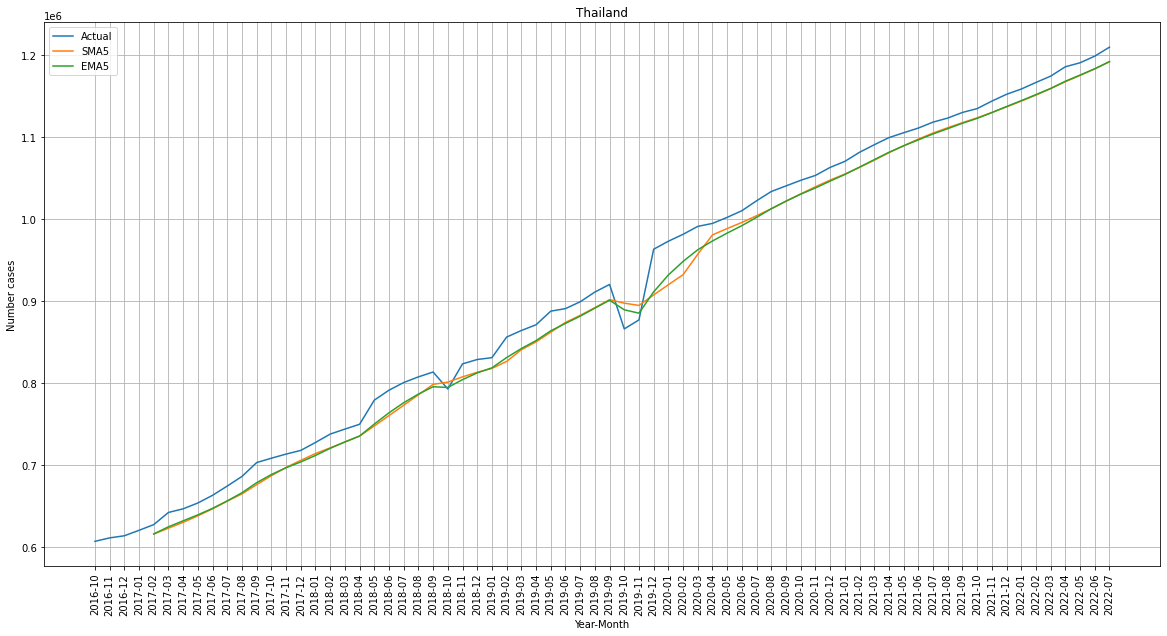

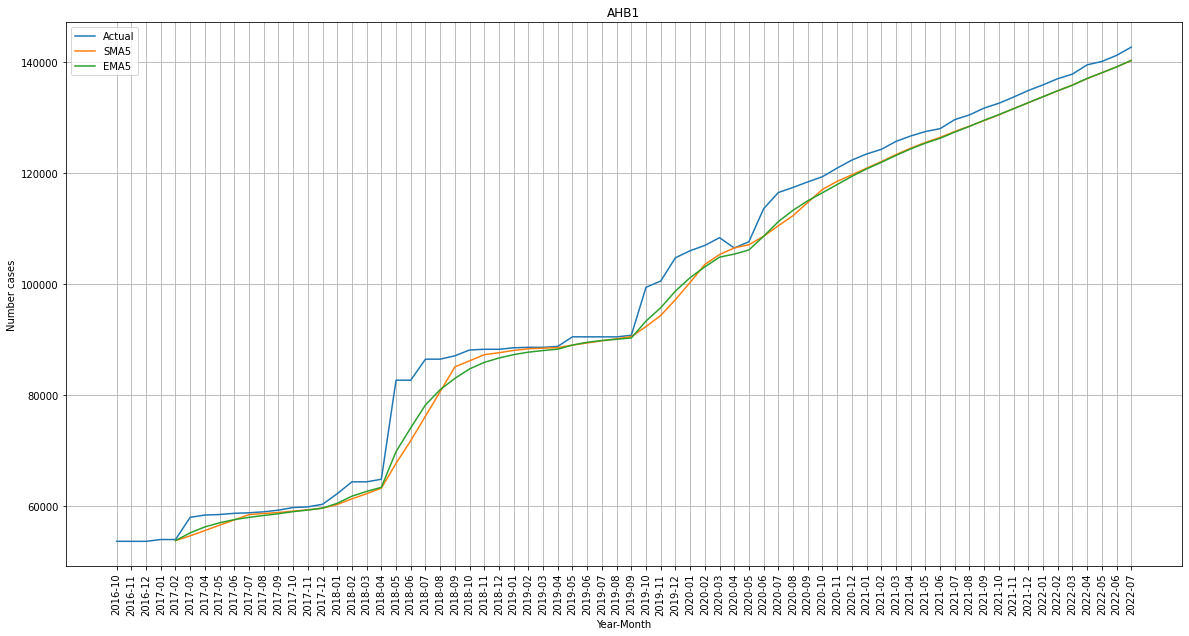

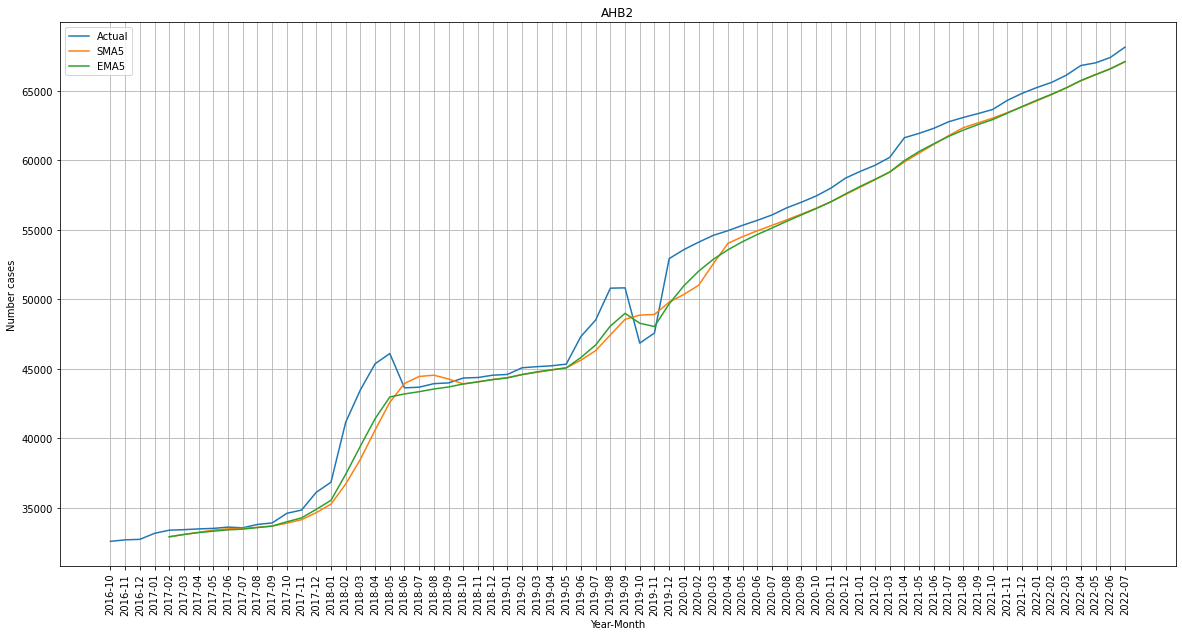

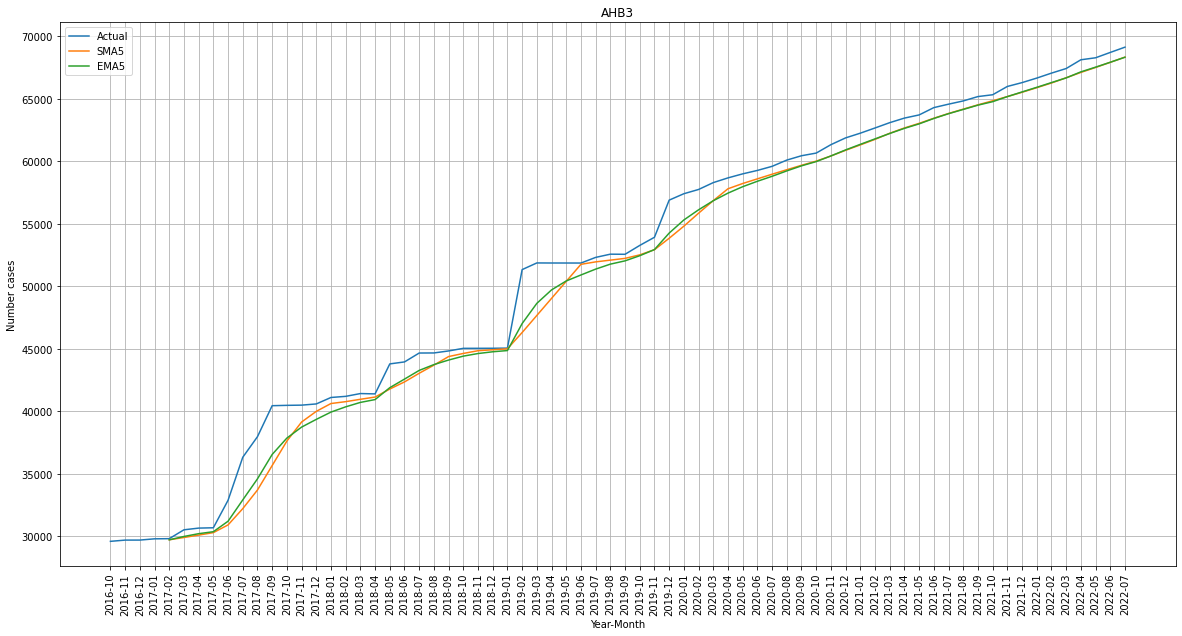

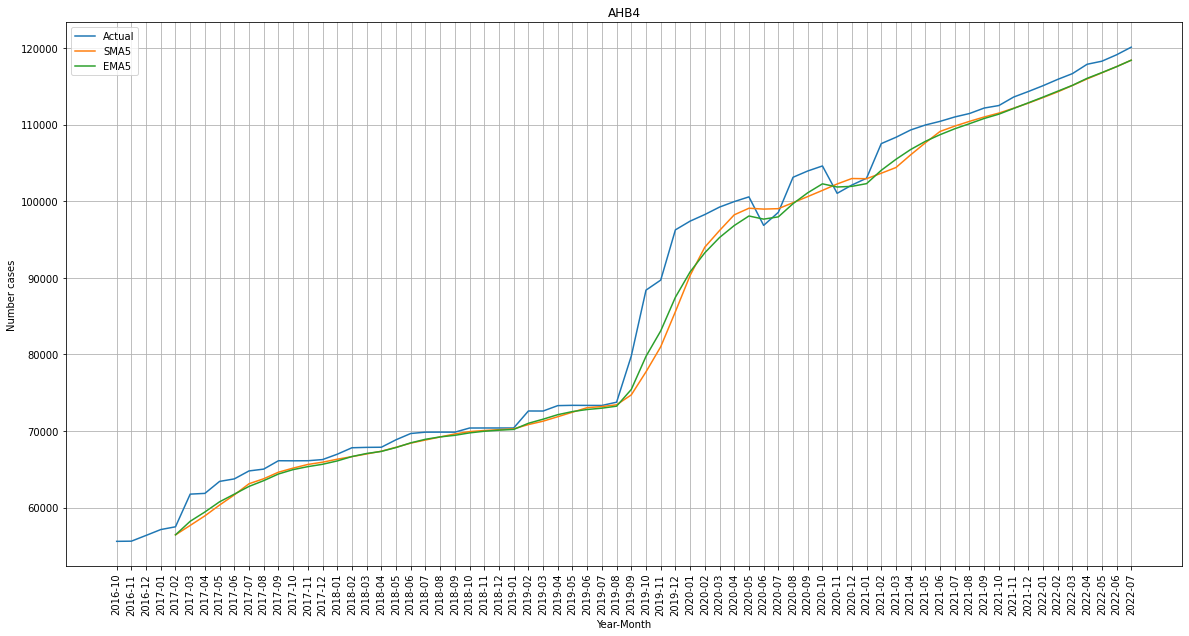

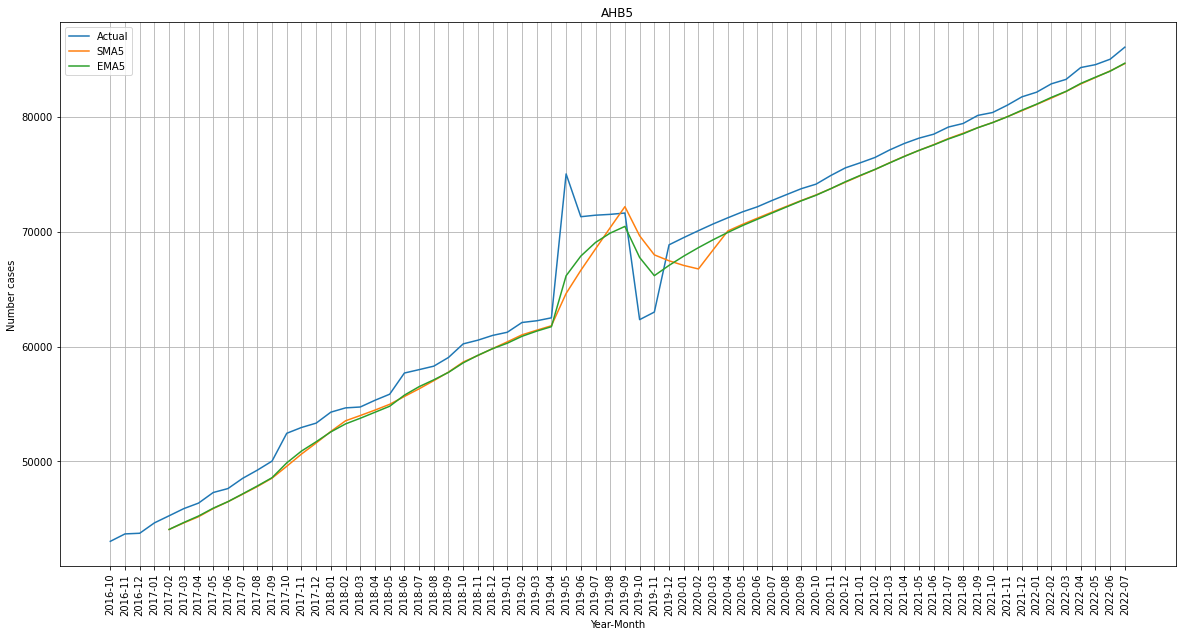

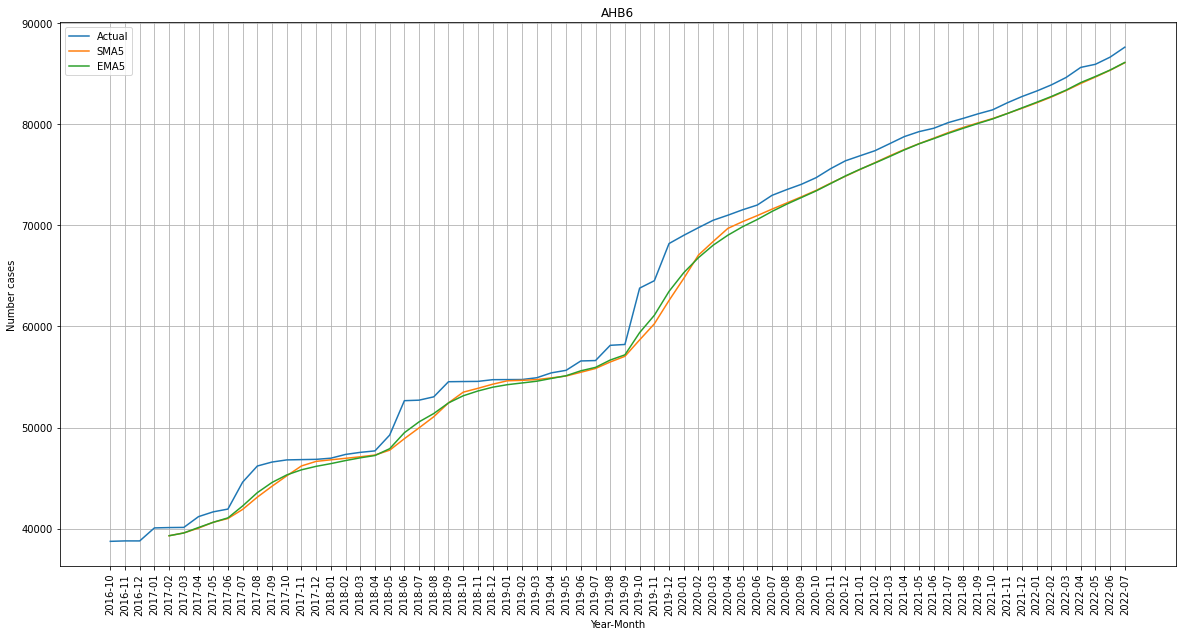

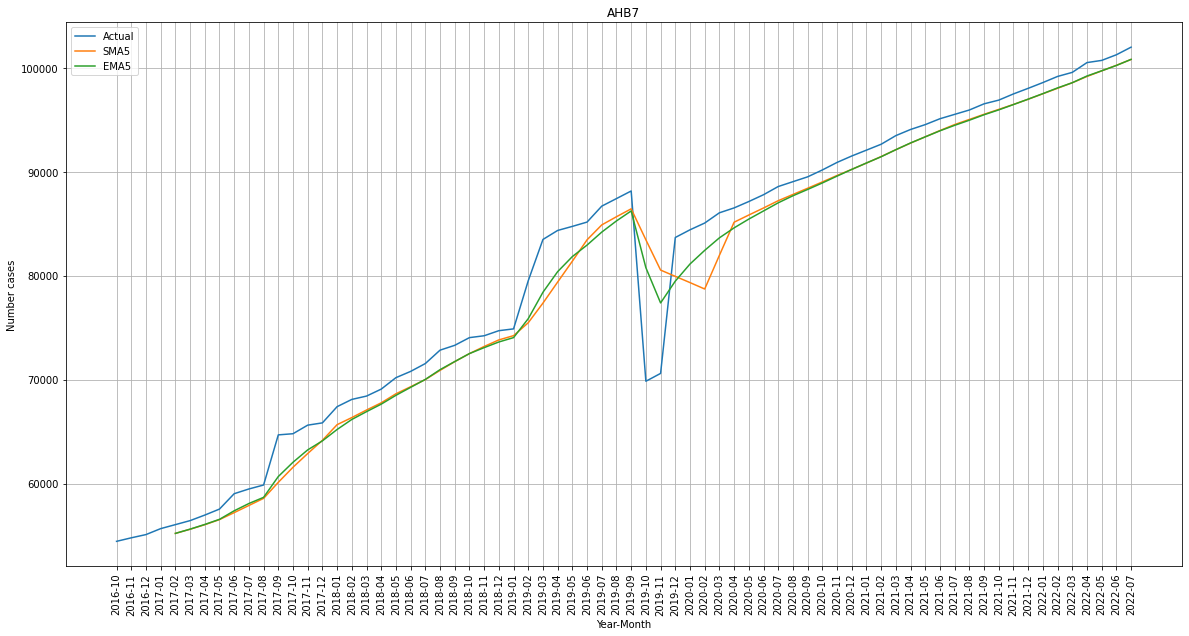

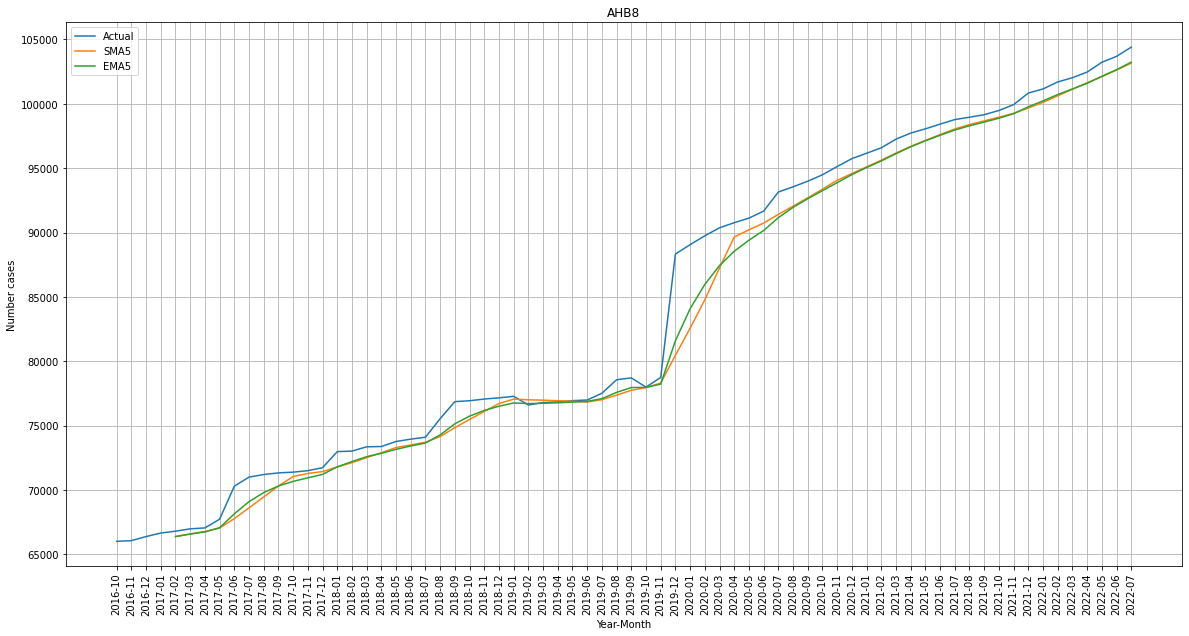

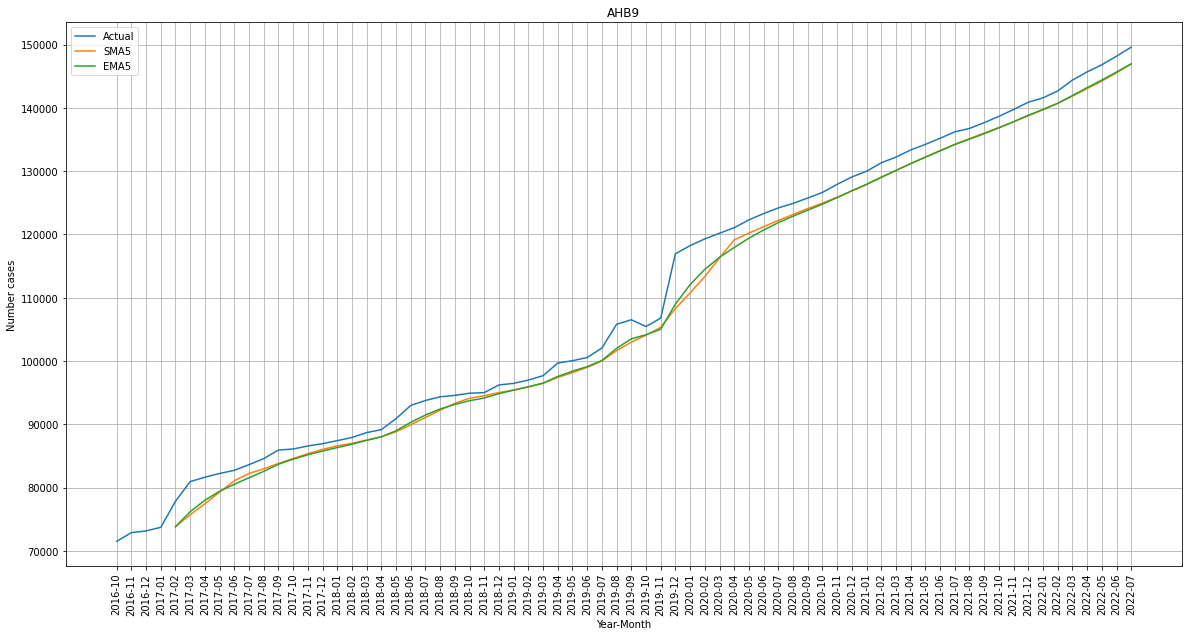

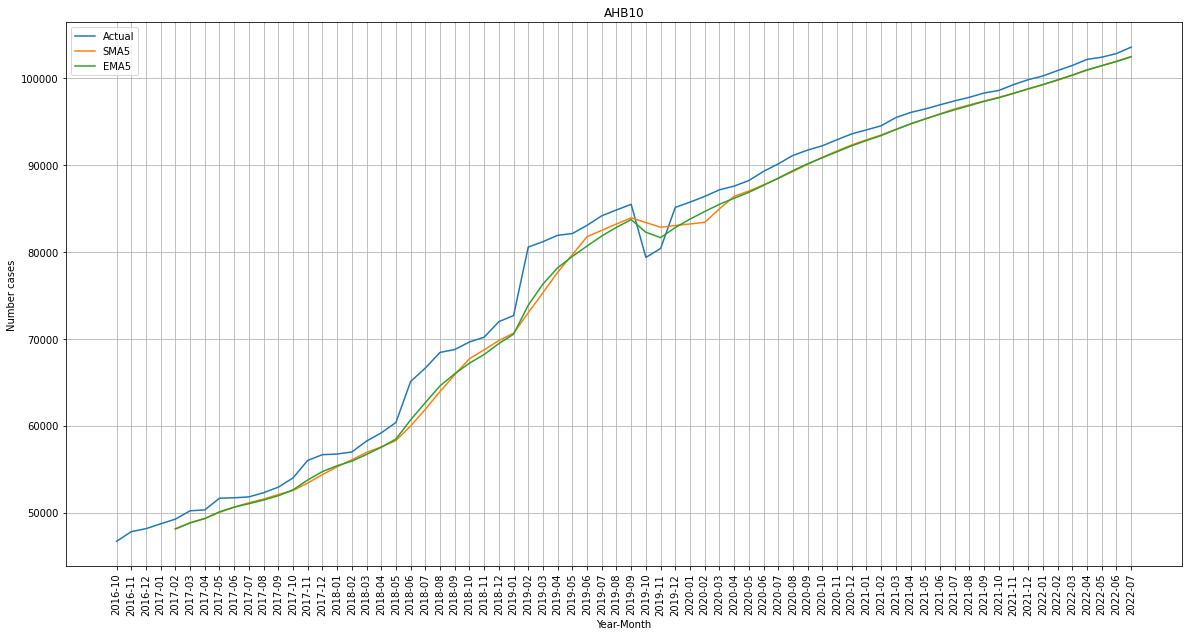

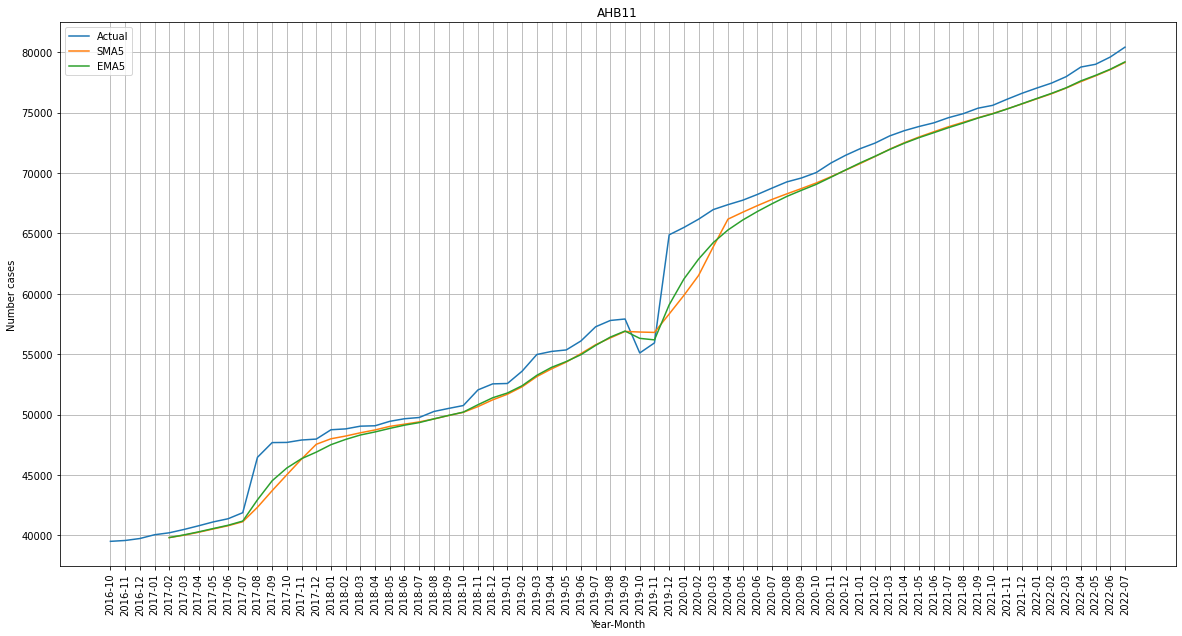

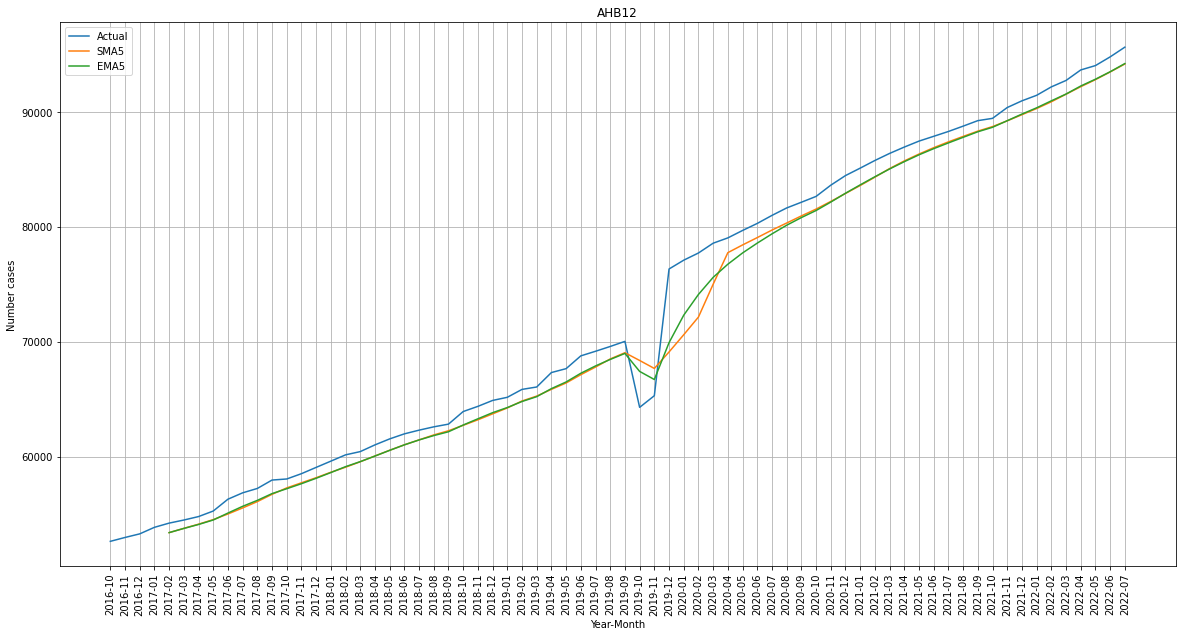

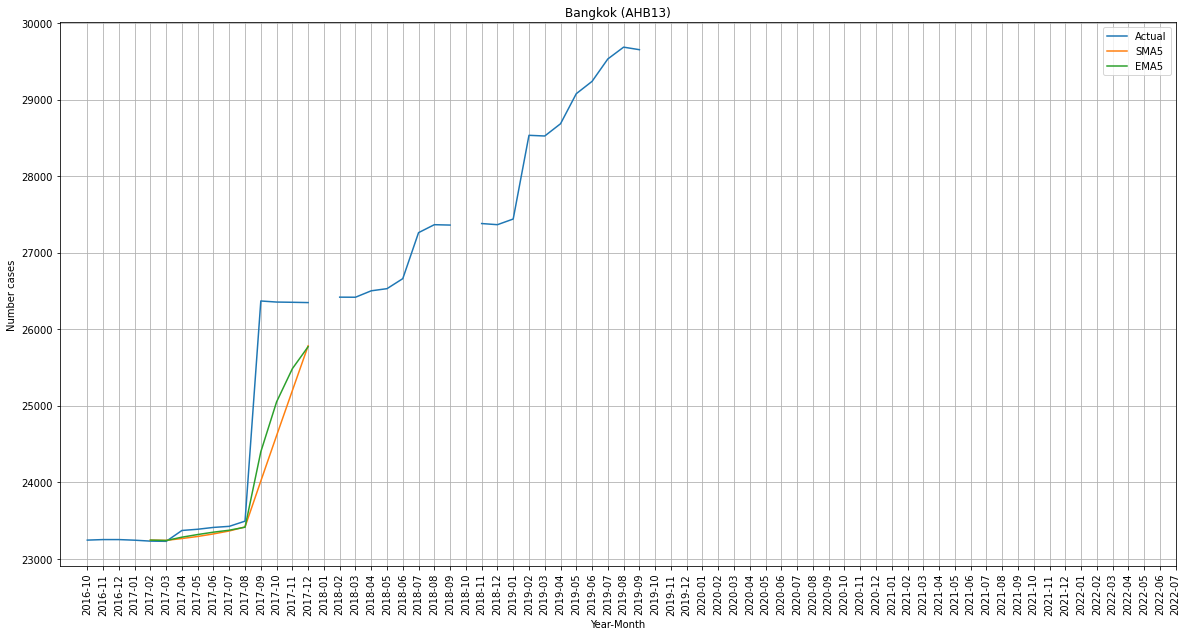

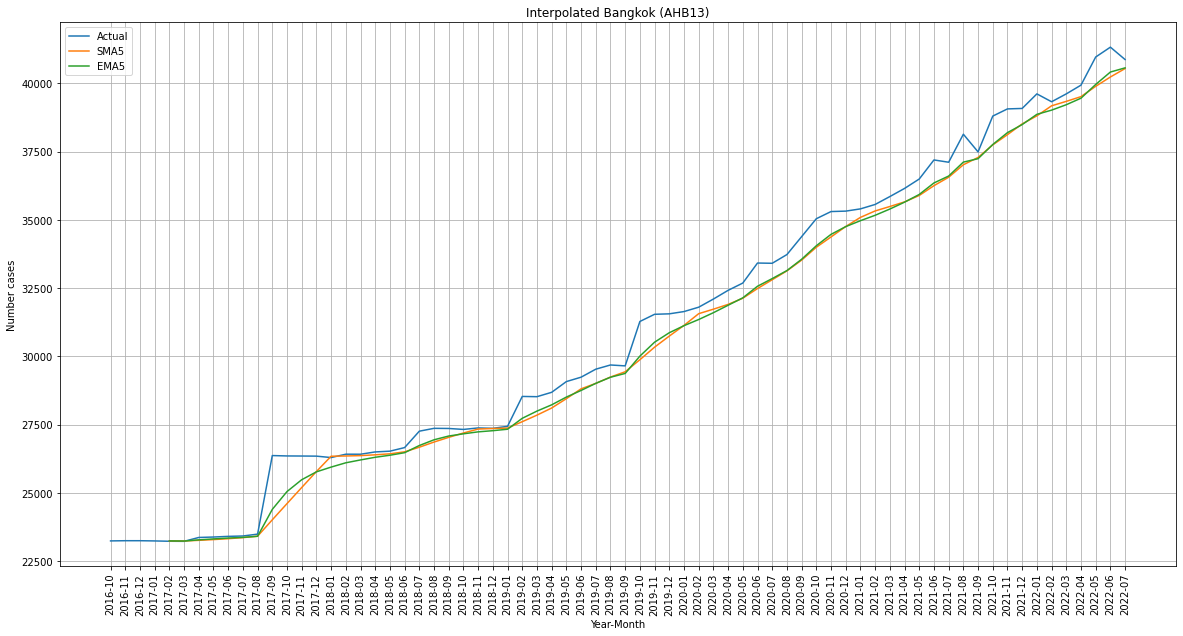

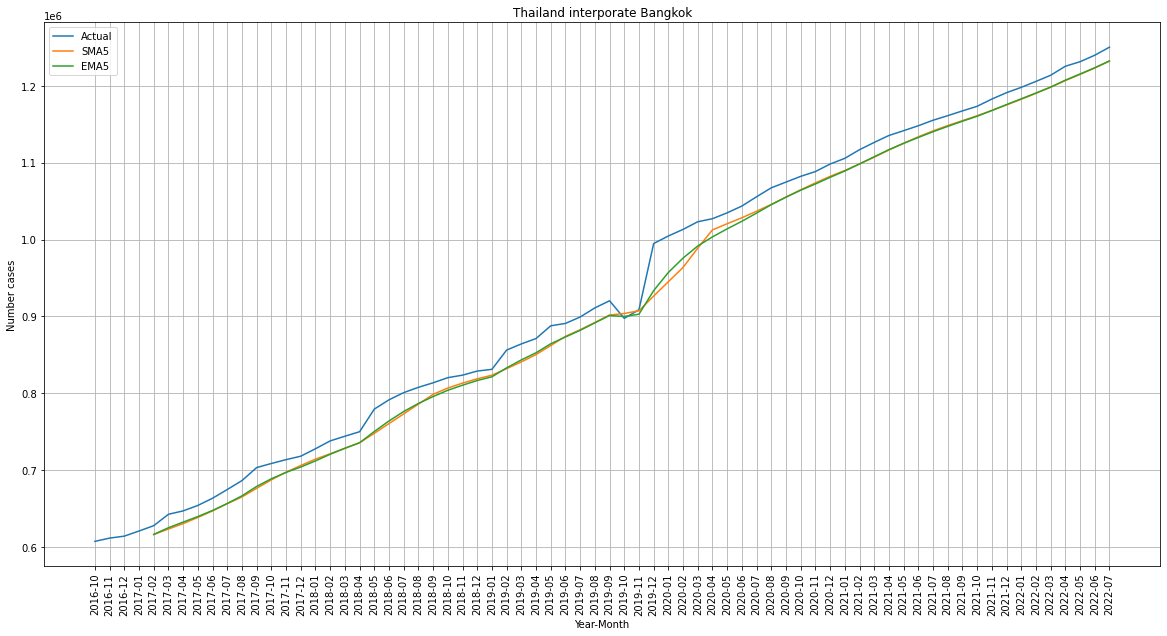

In [5]:
%matplotlib inline
y_name = ['Thailand', 'AHB1', 'AHB2', 'AHB3', 'AHB4', 'AHB5', 'AHB6', 'AHB7', 'AHB8', 'AHB9', 'AHB10', 'AHB11', 'AHB12', 'Bangkok (AHB13)', 'Interpolated Bangkok (AHB13)', 'Thailand interporate Bangkok']
for i in range(len(all_y)):
    all_y[i].plot(kind='line', grid=True, label = "Actual", figsize=(20,10))
    talib.SMA(all_y[i],5).plot(kind='line', grid=True, label = "SMA5")
    talib.EMA(all_y[i],5).plot(kind='line', grid=True, label = "EMA5")

    plt.title(str(y_name[i]))
    plt.ylabel('Number cases')
    plt.xlabel('Year-Month')
    plt.xticks(np.arange(len(all_y[i].index)), list(all_y[i].index), rotation=90)
    plt.legend()
    plt.show()

#ARIMA Model


## Find order p, d, q  

In [6]:
warnings.filterwarnings("ignore")
all_pdq = []
for j in range(len(all_y)):
    # 1 2 3 4 5 6 7 8 9 10 11 12 14 15
    if j == 0 or j == 13:
        continue
    sub_pdq = []
    # Find d 
    adf_res = adfuller(all_y[j], autolag = 'AIC')
    p_value = adf_res[1]
    d = 0
    while(p_value>=0.05):
        diff = all_y[j].diff(d+1)
        d = d + 1
        adf_res = adfuller(diff.dropna(), autolag = 'AIC')
        p_value = adf_res[1]


    # Find p 
    df_pacf = pacf(all_y[j].dropna(), method = 'ols')
    for i in range(0, len(df_pacf)):
        if df_pacf[i] < 1.96 / np.sqrt(len(all_y[j])):
            p = i - 1
            break


    sub_pdq.append(p)
    sub_pdq.append(d)


    # Find q
    aic = []
    possible_q = range(0, 50)

    for i in possible_q:
        try:
            model = ARIMA(all_y[j].dropna() , order = (p,d,i))
            results = model.fit()
            if len(aic)!=0:
                if results.aic > aic[-1]:
                    q = i - 1
                    break 
            aic.append(results.aic)
        except:
            continue
    

    sub_pdq.append(q)
    all_pdq.append(sub_pdq)    
warnings.filterwarnings("default")

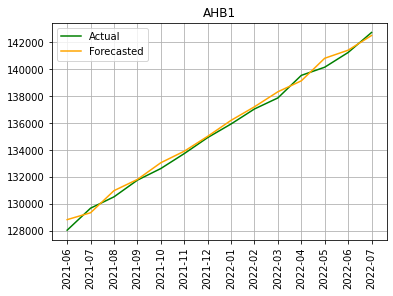

mean_squared_error:154350.86915672757


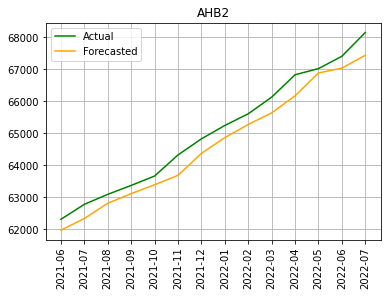

mean_squared_error:195229.21904530516


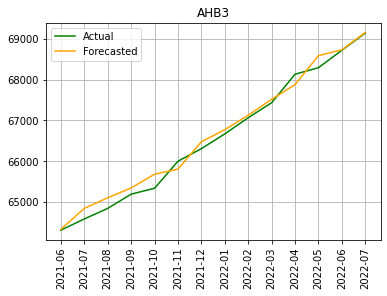

mean_squared_error:37111.08072849331


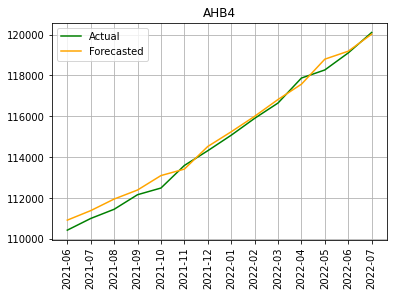

mean_squared_error:113661.82295237164


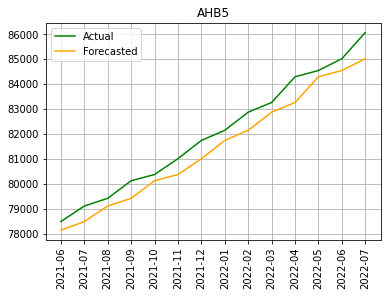

mean_squared_error:385563.69663713645


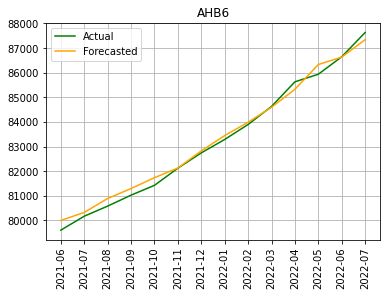

mean_squared_error:58134.80153817491


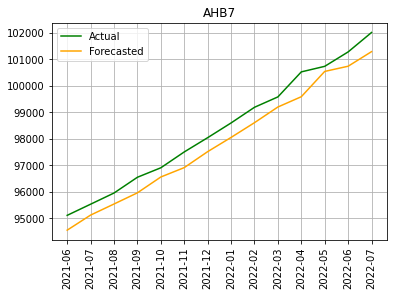

mean_squared_error:303135.58162603434


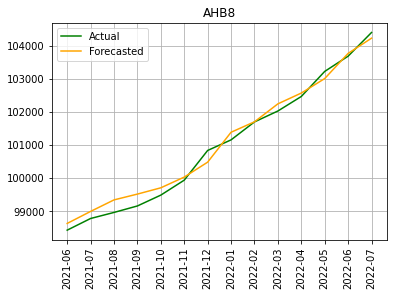

mean_squared_error:52581.830271732026


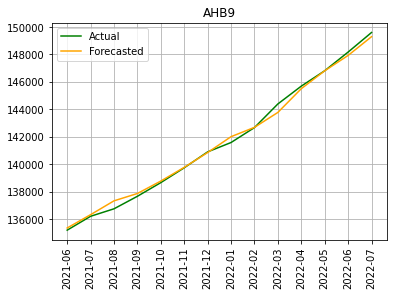

mean_squared_error:84496.80960340203


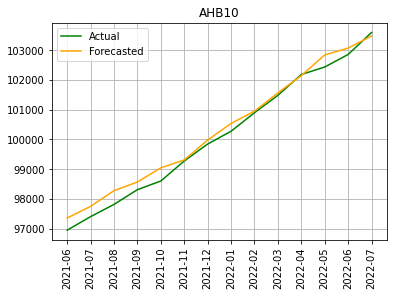

mean_squared_error:77251.8900650636


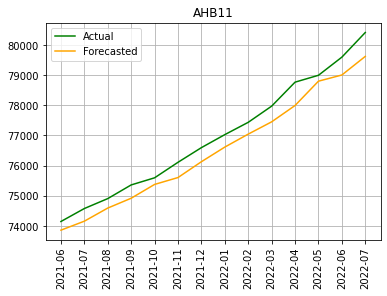

mean_squared_error:234272.92466805593


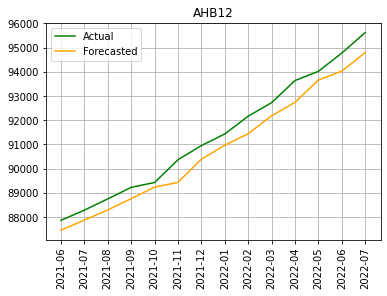

mean_squared_error:370988.3206543078


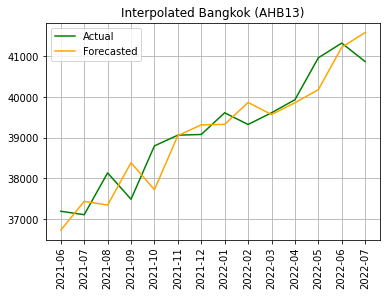

mean_squared_error:319966.4921095804


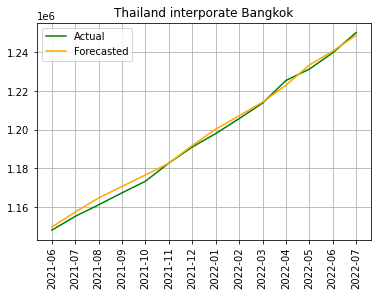

mean_squared_error:4522383.4763173815


In [7]:
%matplotlib inline
warnings.filterwarnings("ignore")
arima_y_name = ['AHB1', 'AHB2', 'AHB3', 'AHB4', 'AHB5', 'AHB6', 'AHB7', 'AHB8', 'AHB9', 'AHB10', 'AHB11', 'AHB12', 'Interpolated Bangkok (AHB13)', 'Thailand interporate Bangkok']
all_arima_error = []
i=0
for j in range(len(all_y)):
    # 1 2 3 4 5 6 7 8 9 10 11 12 14 15
    if j == 0 or j == 13:
        continue
    train_size = int(len(all_y[j]) * 0.8)
    train, test = all_y[j][0:train_size], all_y[j][train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=all_pdq[i])
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    
    plt.plot(test, color = 'green', label = 'Actual')
    plt.plot(predictions, color='orange', label = 'Forecasted')
    plt.grid(1)
    plt.title(str(arima_y_name[i]))
    plt.xticks(np.arange(len(test.index)), list(test.index), rotation=90)
    plt.legend()
    plt.show()
    print("mean_squared_error:" + str(error))
    all_arima_error.append(error)
    i = i + 1
warnings.filterwarnings("default")

#timeseriesAI


119it [00:04, 25.89it/s]
66it [00:01, 34.60it/s]


arch: TSTPlus(c_in=24 c_out=1 seq_len=144 device=cuda:0, arch_config={}, kwargs={})


epoch,train_loss,valid_loss,_rmse,time
0,221.733047,188.037277,13.712668,00:00
1,228.982605,188.990616,13.747386,00:00
2,224.688034,189.730698,13.774276,00:00
3,219.395767,190.249710,13.793103,00:00
4,218.536362,190.470444,13.801104,00:00
5,217.798843,190.413864,13.799052,00:00
6,214.219894,190.114792,13.788212,00:00
7,211.163635,189.557800,13.767999,00:00
8,205.882462,188.759216,13.738968,00:00
9,201.903687,187.750473,13.702207,00:00


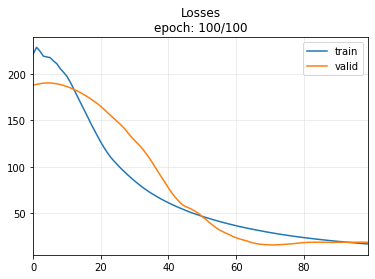

/usr/local/lib/python3.7/dist-packages/tsai/callback/core.py:110: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  if x_bounds is not None: self.graph_ax.set_xlim(*x_bounds)


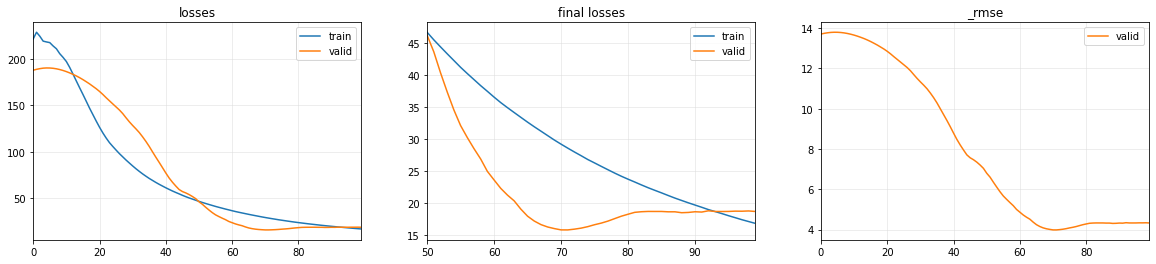

In [8]:
X, y, splits = get_regression_data('AppliancesEnergy', split_data=False)
batch_tfms = TSStandardize(by_sample=True)
reg = TSRegressor(X, y, splits=splits, path='models', arch=TSTPlus, batch_tfms=batch_tfms, metrics=rmse, cbs=ShowGraph(), verbose=True)
reg.fit_one_cycle(100, 3e-4)
reg.export("reg.pkl")

In [ ]:
%matplotlib inline
warnings.filterwarnings("ignore")
deep_uni_y_name = ['AHB1', 'AHB2', 'AHB3', 'AHB4', 'AHB5', 'AHB6', 'AHB7', 'AHB8', 'AHB9', 'AHB10', 'AHB11', 'AHB12', 'Interpolated Bangkok (AHB13)', 'Thailand interporate Bangkok']
all_deep_uni_pred = []
all_deep_uni_target = []
for j in range(len(all_y)):
    # 1 2 3 4 5 6 7 8 9 10 11 12 14 15
    if j == 0 or j == 13:
        continue
    ts = []
    for i in range(len(all_y[j])):
        temp = []
        temp.append(all_y[j][i])
        ts.append(temp)
    X, y = SlidingWindow(60, horizon=1)(np.array(ts))
    splits = TimeSplitter(15)(y) 
    batch_tfms = TSStandardize()
    fcst = TSForecaster(X, y, splits=splits, path='models', batch_tfms=batch_tfms, bs=512, arch=TSTPlus, metrics=mae, cbs=ShowGraph())
    fcst.fit_one_cycle(50, 1e-3)
    fcst.export("fcst.pkl")
    fcst = load_learner("models/fcst.pkl", cpu=False)
    raw_preds, target, preds = fcst.get_X_preds(X[splits[0]], y[splits[0]])
    all_deep_uni_pred.append(preds)
    all_deep_uni_target.append(target)

IndexError: ignored

In [ ]:
ts = get_forecasting_time_series("Sunspots").values

Dataset: Sunspots
downloading data...
...data downloaded. Path = data/forecasting/Sunspots.csv


In [ ]:
y

array([132622, 133730, 134921, 135933, 137049, 137869, 139544, 140152,
       141246, 142732])

In [ ]:
splits

((#2940) [0,1,2,3,4,5,6,7,8,9...],
 (#235) [2940,2941,2942,2943,2944,2945,2946,2947,2948,2949...])

In [ ]:
X.shape

(3173, 1, 60)

In [ ]:
ts

array([[ 96.7],
       [104.3],
       [116.7],
       ...,
       [ 13.2],
       [ 15.9],
       [  1.6]])

In [ ]:
fcst = load_learner("models/fcst.pkl", cpu=False)
raw_preds, target, preds = fcst.get_X_preds(X[splits[0]], y[splits[0]])

torch.Size([2940, 1])

In [ ]:
target

tensor([  0.0000,   5.0000,   2.8000,  ...,  78.5000,  97.3000, 119.2000])